# Analysing 3D astronomical data

In [79]:
# Let's import the modules we are going to use here
import os
import sys
import numpy as np
import numpy.ma as ma
from scipy import ndimage
import astropy.io.fits as pf
import matplotlib.pyplot as plt

# Tell the notebook to display the plots inline
%matplotlib inline

The data we are using come from an astronomical survey called HOPS (http://hops.org.au). The data show the distribution (x, y, velocity) of three spectral lines of ammonia and water in part of the Galaxy. For each molecule, there are files like this:

* H2O_cube.fits = 3D data cube
* H2O_SN.fits = signal-to-noise map of emission

The files are in FITS (Flexible Image Transport System) format, widely used in astronomy. We use a python module called astropy to read the image data and associated meta-data. There are many other modules to read other scientific data formats (GEO-TIFF, GEO-RASTER, DICOM, HDF5 etc.) and almost all convert the data into numpy arrays and python dictionaries.

First, lets take a look at the signal-to-noise map for each molecule.

In [65]:
# Load in the metadata header and data array
head = pf.getheader("dataHOPS/NH322_SN.fits")
data = pf.getdata("dataHOPS/NH322_SN.fits")
print(type(head), len(head))
print(type(data), data.shape, data.dtype)

<class 'astropy.io.fits.header.Header'> 23
<class 'numpy.ndarray'> (72, 145) >f4


The data is loaded into a 2D numpy array of shape (y=72px, x=145px) and data-type 'f4' = 32-bit floating point. The header is actually a kind dictionary with 23 entries.

In [66]:
# Print the header
for key in head.keys():
    print(key, "=", head[key])

SIMPLE = True
BITPIX = -32
NAXIS = 2
NAXIS1 = 145
NAXIS2 = 72
CTYPE1 = GLON
CRVAL1 = 4.50009550012
CRPIX1 = -3657.0
CDELT1 = -0.00833333394486
CTYPE2 = GLAT
CRVAL2 = -0.00111728914947
CRPIX2 = 64.0
CDELT2 = 0.00833333394328
BUNIT = K
RESTFREQ = 23722633335.0
CELLSCAL = CONSTANT
BMAJ = 0.0416666679084
BMIN = 0.0416666679084
BPA = 0.0
ORIGIN = Miriad fits: Revision 1.15, 2010/05/24 16:40:23 UTC
DATAMIN = 0.3718823492527
DATAMAX = 7.0637774467468
HISTORY = kvis: Module version 1.0.3  Karma v1.7.25  compiled with v1.7.25


In [67]:
# Show the raw data array
print(data)

[[        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]
 ..., 
 [ 0.81361133  0.73181725  0.80860156 ...,  0.78878361  0.78827477
   0.80541641]
 [ 0.67293769  0.70978969  0.68146265 ...,  0.7163763   0.7587176
   0.68748569]
 [ 0.8461538   0.73320258  0.70616806 ...,  1.01900291  1.02168083
   0.84069097]]


Notice that the data array contains NaNs (not-a-numbers), which are used in some data formats as 'blank' values. This means that we need to use special numpy methods that know to ignore NaNs. 

In [68]:
# Measure some statistics of the signal-to noise map
zMin = np.nanmin(data)
zMax = np.nanmax(data)
zStd = np.nanstd(data)
print(zMin, zMax, zStd)

0.371882 7.06378 0.619323


In [69]:
# There is no np.nanmedian, so we need to define our own function based on the masked version of median
# Here we use the 'ma.masked_where' to tell numpy to mask the array when 'arr!=arr'.
def nanmedian(arr, **kwargs):
    """Returns median ignoring NaN"""    
    return ma.median( ma.masked_where(arr!=arr, arr), **kwargs )
zMed = nanmedian(data)
print(zMed)

0.829949438572


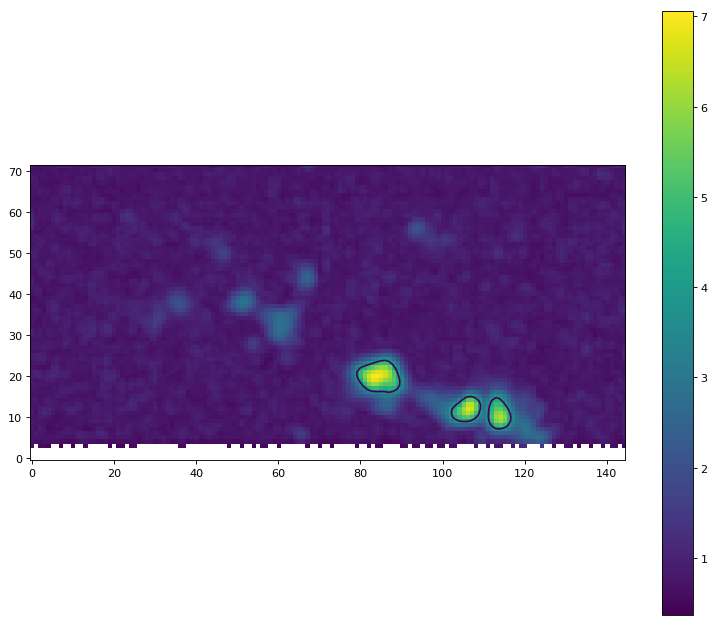

In [70]:
# Lets plot the signal-to-noise map and contours of high-S/N regions we want to analyse
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(data, origin='lower')
plt.colorbar()
levels=np.array([zMed+5*zStd, zMax])
plt.contour(data, levels=levels)

The signal-to-noise data allows us to define regions that we want to analyse separately - in this case distinct clumps of emission. We can make a mask to select data from the 3D spectral data-cube.

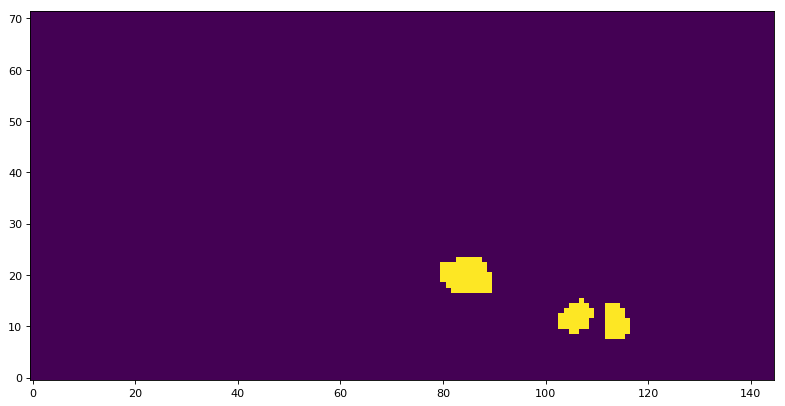

In [77]:
# Make a binary mask at the level selected by the contour plot above.
dataNoNaN = np.nan_to_num(data)      # Convert NaNs to zeros for this operation
mask = np.where(dataNoNaN >= zMed+5*zStd, 1, 0)

# Plot the mask
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(mask, origin='lower')

Found 3 islands in image.


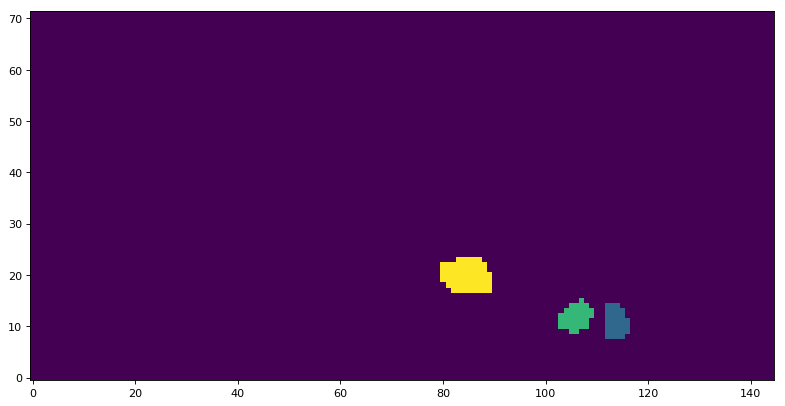

In [85]:
# Now segment the mask using a nifty scipy tool
maskLabeled, nIslands = ndimage.label(mask)
print("Found %d islands in image." % nIslands)

# This allows us to plot the islands of emission in different colours
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(maskLabeled, origin='lower')

One of the most common analysis task is to measure positions of regions. The scipy 'find_objects' function returns islands in a labeled mask and we can write a function to calculate the centroid of each island.

In [82]:
# Define a function to calculate the centroid of the island
def centroid(data):
    """Calculate the centroid of a 2D data array,"""
    h, w = np.shape(data)   
    x = np.arange(0, w)
    y = np.arange(0, h)
    X,Y = np.meshgrid(x,y)
    cx = np.sum(X*data)/np.sum(data)
    cy = np.sum(Y*data)/np.sum(data)
    return cx, cy

In [168]:
# Now extract the positions for each island and plot on the original image

# First the indices of the pixels in the island
islands = ndimage.find_objects(maskLabeled)

# Then loop through the islands, measuring position
X_pix = []
Y_pix = []
islandLst = []
for i, island in enumerate(islands):
    nPix = np.sum(mask[island])
    x, y = dx.start, dy.start
    cx, cy = centroid(mask[island])
    X_pix.append(x + cx)
    Y_pix.append(y + cy)
    islandLst.append(island)
    print("Island %d: %d pixels, (x, y) = (%.1f, %.1f)... " % (i, nPix, X_pix[-1], Y_pix[-1]))

Island 0: 30 pixels, (x, y) = (81.7, 19.8)... 
Island 1: 32 pixels, (x, y) = (83.0, 19.8)... 
Island 2: 60 pixels, (x, y) = (84.6, 19.8)... 


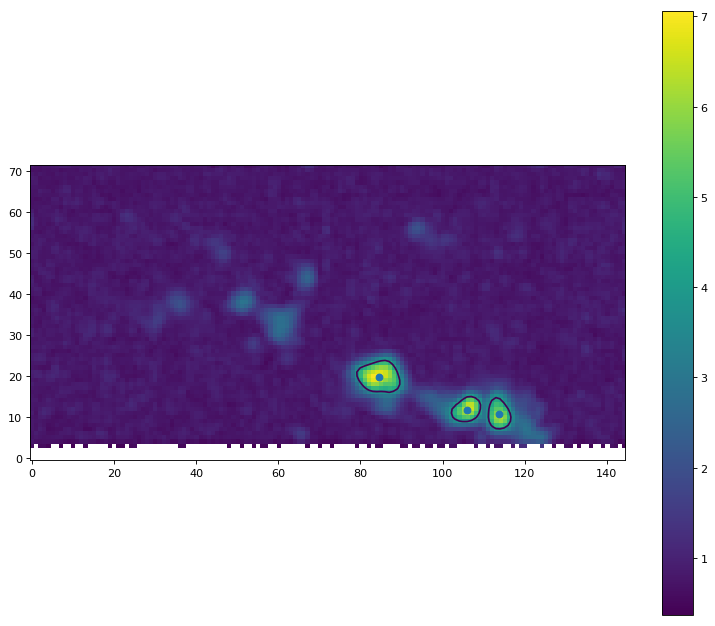

In [89]:
# Plot the positions on the signal-to-noise map
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(data, origin='lower')
plt.colorbar()
levels=np.array([zMed+5*zStd, zMax])
plt.contour(data, levels=levels)
plt.scatter(X_pix, Y_pix)

So now we positions and masks for our regions of interest. We want to look at our spectral data in each region - perhaps at the centroid, the peak pixel and an average over each region.

In [141]:
# Load the data from the NH3(1,1) and NH3(2,2) cubes
# The cubes have the same velocity (s) scale and shape, so we only need to get the meta-data once
head = pf.getheader("dataHOPS/NH311_cube.fits")
data11 = pf.getdata("dataHOPS/NH311_cube.fits")
data22 = pf.getdata("dataHOPS/NH322_cube.fits")
print(type(head), len(head))
print(type(data11), data11.shape, data11.dtype)

<class 'astropy.io.fits.header.Header'> 28
<class 'numpy.ndarray'> (931, 72, 145) >f4


In [208]:
# FITS files contain information on a simple linear tranform to convert from channel to velocity
chans = np.arange(data11.shape[0])
z_kms = (head['CRVAL3'] + ( (chans - head['CRPIX3']) * head['CDELT3'] ))/1000.

(931,)

The header is the same in both files, but this time the data is a 3D array (z, y, x). Lets extract spectra from the centroid of each region and display on a single plot.

In [144]:
# Create a list to hold the spectra
spec11Lst = []
spec22Lst = []

# Loop through the pixel positions and extract the data
for i in range(len(X_pix)):
    x = int(round(X_pix[i]))
    y = int(round(Y_pix[i]))
    spec11Lst.append(data11[:, y, x])
    spec22Lst.append(data22[:, y, x])

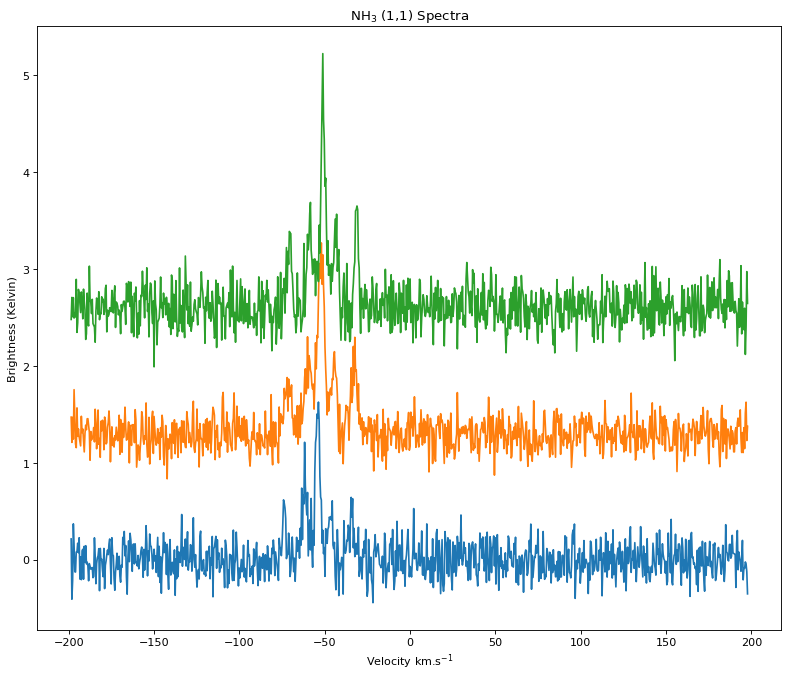

In [151]:
# Plot the NH3 (1,1) spectra
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
offset = 0.0
for i in range(len(X_pix)):
    plt.plot(z_kms, spec11Lst[i]+offset)
    offset +=1.3
plt.xlabel("Velocity km.s$^{-1}$")
plt.ylabel("Brightness (Kelvin)")
plt.title(r"NH$_3$ (1,1) Spectra")

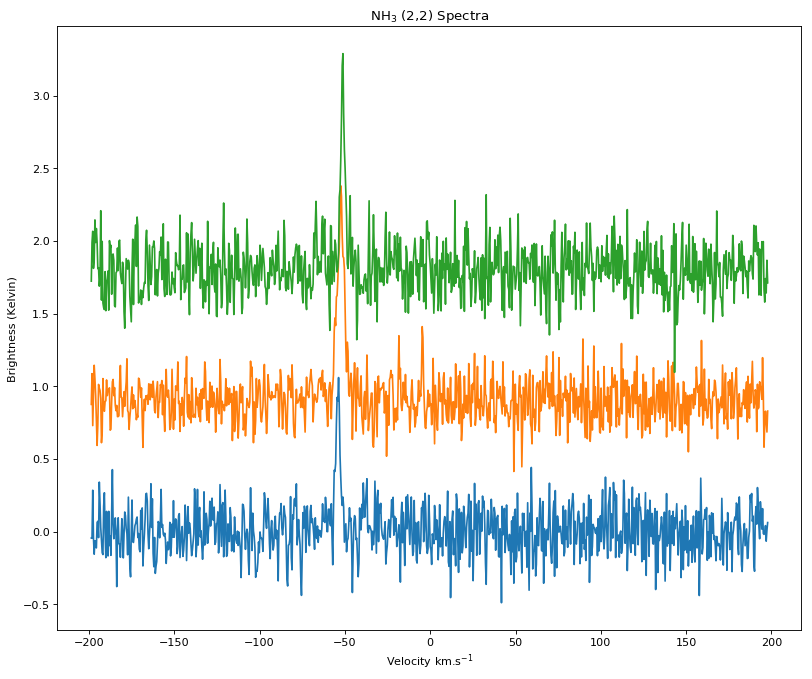

In [153]:
# Plot the NH3 (2,2) spectra
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
offset = 0.0
for i in range(len(X_pix)):
    plt.plot(z_kms, spec22Lst[i]+offset)
    offset +=0.9
plt.xlabel("Velocity km.s$^{-1}$")
plt.ylabel("Brightness (Kelvin)")
plt.title(r"NH$_3$ (2,2) Spectra")

Now lets extract spectra over the pixel-masks and take a sum.

In [215]:
# Create a list to hold the spectra
spec11SumLst = []
spec22SumLst = []

# Expand the 2D mask to hole a new axis
#maskLabeled3D = maskLabeled[np.newaxis,:,:]

# Loop through the pixel positions and extract the data
for i in range(len(islandIndxLst)):
    maskTmp = np.where(maskLabeled==islandIndxLst[i], 1, np.nan)
    dataTmp = data11 * maskTmp
    specSummed = np.nansum(dataTmp, axis=-1)
    specSummed = np.nansum(specSummed, axis=-1)
    spec11SumLst.append(specSummed)

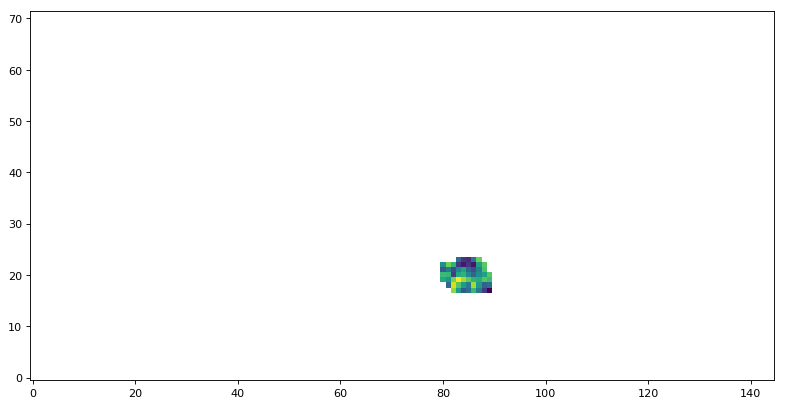

In [216]:

# Plot the mask
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(dataTmp[50], origin='lower')

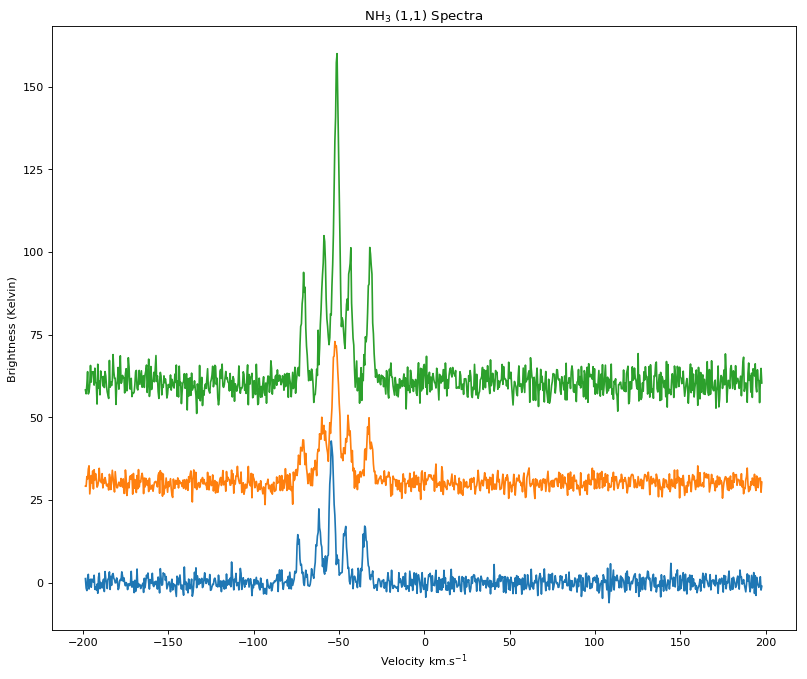

In [218]:
# Plot the NH3 (1,1) spectra
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
offset = 0.0
for i in range(len(X_pix)):
    plt.plot(z_kms, spec11SumLst[i]+offset)
    offset +=30.3
plt.xlabel("Velocity km.s$^{-1}$")
plt.ylabel("Brightness (Kelvin)")
plt.title(r"NH$_3$ (1,1) Spectra")